In [1]:
import sys
#!{sys.executable} -m pip install wordcloud
#!{sys.executable} -m pip install pysentimiento
#!{sys.executable} -m pip install --upgrade pandas

### Import Libraries

In [2]:

# utilities
import re
import numpy as np
import pandas as pd
import pickle 
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
# To read faster the large data 
from dask import dataframe as df1


### Read Data

In [3]:
# Importing the dataset
elongate_tweets_file = 'raw_data/elongate_tweets.csv'
regular_tweets_file = 'raw_data/elonmusktwitter_tweets.csv'
chunk = pd.read_csv(elongate_tweets_file, sep=',', index_col=False, dtype='unicode', chunksize=1000)
elongate_df = pd.concat(chunk)

chunk = pd.read_csv(regular_tweets_file, sep=',', index_col=False, dtype='unicode', chunksize=1000)
regular_df = pd.concat(chunk)

elongate_df.sample(5)


,date,id,content,lang,replyCount,retweetCount,likeCount,inReplyToTweetId,inReplyToUser,mentionedUsers
218630,2022-05-04 01:13:37+00:00,1521659279685607429,"@DraBetalacerda @elonmusk Welcome back, doc!!👏...",en,0,0,1,1.5215488166793298e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u..."
21430,2022-05-04 21:21:18+00:00,1521963202405359624,https://t.co/HmBPZwmu11 My Gen 1 (Fast) NFT fo...,en,0,0,1,NaN,NaN,NaN
91352,2022-05-04 14:35:28+00:00,1521861070201421824,@MsCryptomom1 @elonmusk @boredape101 Great day...,en,0,0,0,1.5218488466614395e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u..."
468319,2022-05-03 00:30:18+00:00,1521285988198207490,@AGomezler @TomBrady @elonmusk https://t.co/kz...,und,0,0,0,1.5148114751429837e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u..."
153262,2022-05-04 10:20:12+00:00,1521796828743618562,WAIT HOLD UP @elonmusk don’t play with my hear...,en,10,9,56,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.User', 'u..."


In [4]:
print(elongate_df.size)
elongate_filter = (elongate_df['lang'] == 'en')

elongate_df = elongate_df[elongate_filter]
print(elongate_df.size)
elongate_df.head(5)

4783210
3597810


,date,id,content,lang,replyCount,retweetCount,likeCount,inReplyToTweetId,inReplyToUser,mentionedUsers
0,2022-05-04 23:59:59+00:00,1522003135794929665,@elonmusk @bevedoni It would make us happy if ...,en,0,0,0,1.5219985677574267e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u..."
1,2022-05-04 23:59:59+00:00,1522003134612127746,@Crypto_Highland @RatsoLicksy @CliffToken @elo...,en,1,0,2,1.522002058949415e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u..."
2,2022-05-04 23:59:59+00:00,1522003134557663235,@elonmusk @bevedoni Word !,en,0,0,0,1.5219985677574267e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u..."
3,2022-05-04 23:59:59+00:00,1522003134238715910,@teslaownersSV @elonmusk He was joking and her...,en,0,0,0,1.5217191082528236e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u..."
4,2022-05-04 23:59:58+00:00,1522003132162658304,@elonmusk @bevedoni It’s very true!,en,0,0,0,1.5219985677574267e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u..."


### Perform Sentiment and Emotion Analysis

We will be using `pysentimiento` a Python Toolkit for Sentiment Analysis and SocialNLP tasks that uses pre-trained Bert and language models to perform the sentiment analysis. 

#### Sentiment Analyzer

In [5]:
from pysentimiento import create_analyzer
sentiment_analyzer = create_analyzer(task="sentiment", lang="en")


#### Emotion Analyzer

In [6]:
emotion_analyzer = create_analyzer(task="emotion", lang="en")

loading configuration file https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/config.json from cache at C:\Users\georg/.cache\huggingface\transformers\c246eed05359b1a49c45955b0265b488e35b0cbd2628e3ead7dd54c8815162ee.a2dff24b4e0a884c6d58a09968c5b68e7391e749eb698ad92541818d420fd01b
Model config RobertaConfig {
  "_name_or_path": "finiteautomata/bertweet-base-emotion-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "others",
    "1": "joy",
    "2": "sadness",
    "3": "anger",
    "4": "surprise",
    "5": "disgust",
    "6": "fear"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "disgust": 5,
    "fear": 6,
    "joy": 1,
    "others": 0,

In [7]:
import pandas as pd
pd.__version__
#%pip install pandas==1.4.1

'1.4.2'

In [19]:
f3 = open('raw_data/elonmusktwitter_tweets_df.obj', 'rb')
df3 = pickle.load(f3)
df3.shape[0]

1475486

In [9]:
#Sentiment Analysis returns 
#NEU = Neutral = 50
#POS = Positive = 100
#NEG = Negative = 0
def analyze(content):
  result = 'Neutral'
  if type(content) == str:
    res = sentiment_analyzer.predict(content)
    if res.output == 'NEG':
      result = 'Negative'
    elif res.output == 'POS':
      result = 'Positive'
  return result


In [20]:

regular_df_sample = regular_df.sample(n=10000)
elongate_df_sample = elongate_df.sample(n=10000)
regular_df_sample.head(5)


,date,id,user_ID,user_name,user_location,content,lang,replyCount,retweetCount,likeCount,inReplyToTweetId,inReplyToUser_ID,inReplyToUser_name,mentionedUsers_ID,mentionedUsers_name
1222716,2022-04-28 21:23:37+00:00,1519789457909727233,1499093027255635976,Jimmyzoupa,NaN,@seanhannity How much would you like to bet @e...,en,0,0,0,1.519788058417283e+18,41634520,seanhannity,"[41634520, 44196397]","['seanhannity', 'elonmusk']"
798121,2022-04-26 18:15:44+00:00,1519017399068274688,1131661879930171396,AlfredoVilaboa,Hurlingham,@JMilei @elonmusk @realDonaldTrump ahora entie...,es,0,0,0,1.518784890174464e+18,4020276615,JMilei,"[4020276615, 44196397, 25073877]","['JMilei', 'elonmusk', 'realDonaldTrump']"
135547,2022-04-06 12:26:45+00:00,1511681817329418242,34121956,squamishsusan,Biosphere,After buying over 9% of @Twitter @elonmusk tak...,en,0,0,0,NaN,0,0,"[783214, 44196397]","['Twitter', 'elonmusk']"
44169,2022-04-04 12:16:54+00:00,1510954561736830982,540587274,KilaFateh,Union of India,"Haha 😃 true to his tweet, @elonmusk is now hol...",en,0,0,1,NaN,0,0,"[44196397, 783214, 1291945442]","['elonmusk', 'Twitter', 'PPathole']"
692105,2022-04-22 15:07:30+00:00,1517520478235156480,97767641,Optionparty,Minnesota,@elonmusk Sell lots of Naked Puts on Twitter.\...,en,0,0,1,1.5172150665501164e+18,44196397,elonmusk,[44196397],['elonmusk']


In [21]:
regular_df_sample_content = regular_df_sample['content'].values
elongate_df_sample_content = elongate_df_sample['content'].values


In [22]:
elongate_df_sentiment = [analyze(x) for x in elongate_df_sample_content]



In [23]:
# Saving the objects since the analysis takes a long time
with open('raw_data/elongate_df_sentiment.obj', 'wb') as elongate_df_sentiment_file:
  pickle.dump(elongate_df_sentiment, elongate_df_sentiment_file)

In [24]:
regular_df_sentiment = [analyze(x) for x in regular_df_sample_content]

In [25]:
# Saving the objects since the analysis takes a long time
with open('raw_data/regular_df_sentiment.obj', 'wb') as regular_df_sentiment_file:
  pickle.dump(regular_df_sentiment, regular_df_sentiment_file)

Encoding Categorical Variable:

Initially I have mapped an index to the different levels of sentiment:

In [26]:
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
pred_lbl = lbl.fit_transform(regular_df_sentiment)
mappings = {index: label for index, label in enumerate(lbl.classes_)}
mappings

{0: 'Negative', 1: 'Neutral', 2: 'Positive'}

In [27]:
dummy_features = pd.get_dummies(regular_df_sentiment)
dummy_features


,Negative,Neutral,Positive
0,0,1,0
1,0,1,0
2,0,0,1
3,0,0,1
4,0,1,0
...,...,...,...
9995,1,0,0
9996,0,1,0
9997,0,1,0
9998,0,1,0


In [28]:
regular_df_sample['sentiment'] = regular_df_sentiment
regular_df_sample.head(5)['sentiment']

1222716     Neutral
798121      Neutral
135547     Positive
44169      Positive
692105      Neutral
Name: sentiment, dtype: object

In [29]:
at=pd.concat([regular_df_sample[['content', 'sentiment']],
dummy_features.set_index(regular_df_sample.index)], axis=1)
at.head(9)
#This file gets saved as 'regular_sentiment_sample.csv' for future reference

,content,sentiment,Negative,Neutral,Positive
1222716,@seanhannity How much would you like to bet @e...,Neutral,0,1,0
798121,@JMilei @elonmusk @realDonaldTrump ahora entie...,Neutral,0,1,0
135547,After buying over 9% of @Twitter @elonmusk tak...,Positive,0,0,1
44169,"Haha 😃 true to his tweet, @elonmusk is now hol...",Positive,0,0,1
692105,@elonmusk Sell lots of Naked Puts on Twitter.\...,Neutral,0,1,0
912279,I guess Elon Musk was able to buy Twitter beca...,Neutral,0,1,0
168998,@Benmzondo @Blacksmitheart @laurenboebert @elo...,Neutral,0,1,0
573493,What if @elonmusk buys @Twitter and replaces i...,Neutral,0,1,0
567274,"@elonmusk 'Wurg hom, Dirkie!' @Twitter !! 😂",Positive,0,0,1


In [37]:
print('REGULAR TWEETS:')
print('Negative Proportion:', at['Negative'].mean())
print('Positive Proportion:', at['Positive'].mean())
print('Neutral Proportion:', at['Neutral'].mean())

REGULAR TWEETS:
Negative Proportion: 0.3173
Positive Proportion: 0.1199
Neutral Proportion: 0.5628


Elon Tweets About Twitter Purchase: 

In [39]:
elongate_dummy_features = pd.get_dummies(elongate_df_sentiment)
elongate_dummy_features

elongate_df_sample['sentiment'] = elongate_df_sentiment
elongate_df_sample.head(5)['sentiment']

elongate_at=pd.concat([elongate_df_sample[['content', 'sentiment']],
elongate_dummy_features.set_index(elongate_df_sample.index)], axis=1)
elongate_at.head(9)
#This table gets saved as 'elongate_sentiment_sample.csv' for future reference

print('TWITTER PURCHASE SENTIMENT:')
print('Negative Proportion:', elongate_at['Negative'].mean())
print('Positive Proportion:', elongate_at['Positive'].mean())
print('Neutral Proportion:', elongate_at['Neutral'].mean())

TWITTER PURCHASE SENTIMENT:
Negative Proportion: 0.3574
Positive Proportion: 0.2235
Neutral Proportion: 0.4191


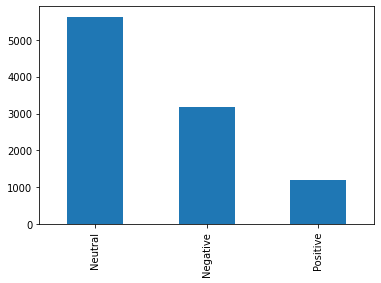

In [42]:
at['sentiment'].value_counts().plot(kind='bar')
#at.to_csv('raw_data/regular_sentiment_sample.csv')

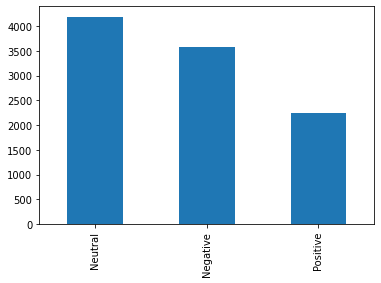

In [43]:
elongate_at['sentiment'].value_counts().plot(kind='bar')
#elongate_at.to_csv('raw_data/elongate_sentiment_sample.csv')

In both the `regular` and `elon buys twitter` sets of tweets, we notice a majority of the sentiment is neutral.  However, can see a more marked reaction to the news that Elon wants to buy Twitter.  This makes sense, we see a greater positive sentiment on these tweets than on mundane Elon Musk Tweets but, at the same time, we see an increase in the negative sentiment tweets as well. It can be argued that the news is more interesting and, therefore, reduces the apathy of the normal tweets. 